In [1]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# Set the directory where your PhysioNet data is stored
data_path = "data/training2017"

# Read the reference file (contains labels)
labels_df = pd.read_csv(f'{data_path}/REFERENCE.csv', header=None, names=['record_name', 'label'])


### We are not able to get good performance using ARIMA for feature extraction. 
So, none of the code here are used. But we are keeping it to show we explored using ARIMA.

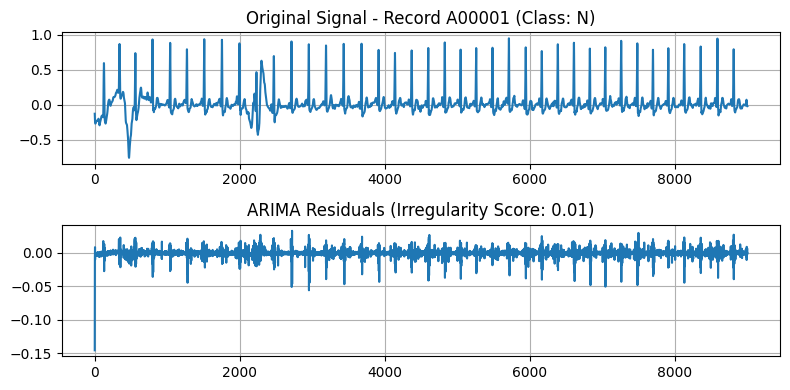

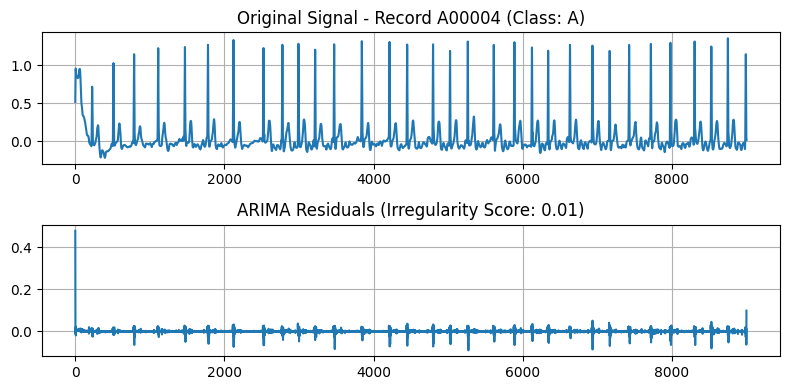

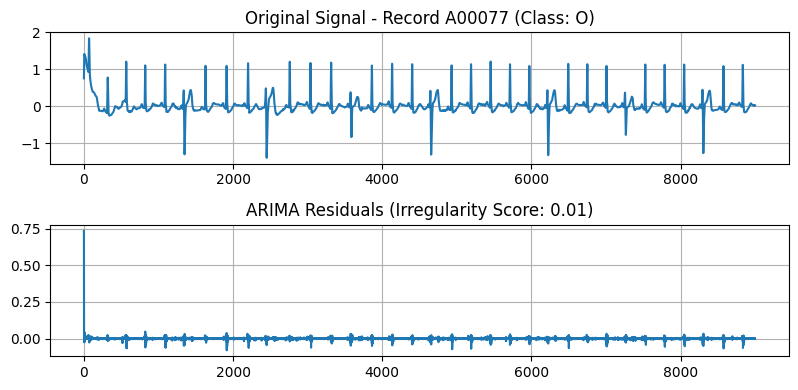

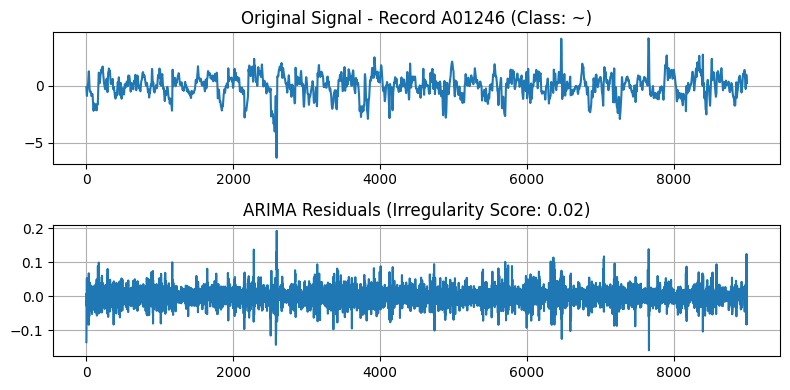


ARIMA Analysis Results:
  record_id label  irregularity_score  adf_statistic    adf_pvalue
0    A00001     N            0.005319     -16.330978  3.061166e-29
1    A00004     A            0.008464     -13.723021  1.178135e-25
2    A00077     O            0.010016     -13.238912  9.256520e-25
3    A01246     ~            0.021332      -9.582161  2.144073e-16


In [2]:
def analyze_arima(record_name, data_path, labels_df, plot=False):
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    label = labels_df[labels_df.record_name == record_id].label.values[0]
    
    # Perform Augmented Dickey-Fuller test for stationarity
    adf_result = adfuller(signals)
    
    # Fit ARIMA model
    # Using order=(5,1,5) as an example - you might need to tune these parameters
    model = ARIMA(signals, order=(4, 0, 4))
    results = model.fit()
    
    # Get residuals (prediction errors)
    residuals = results.resid
    
    # Calculate irregularity metrics
    irregularity_score = np.std(residuals)

    if plot:
        # Plot original signal and residuals
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
        
        ax1.plot(signals)
        ax1.set_title(f'Original Signal - Record {record_name} (Class: {label})')
        ax1.grid(True)
        
        ax2.plot(residuals) 
        ax2.set_title(f'ARIMA Residuals (Irregularity Score: {irregularity_score:.2f})')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'record_id': record_name,
        'label': label,
        'irregularity_score': irregularity_score,
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1]
    }

# Test on a few records
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
arima_results = []

for record_id in record_ids:
    result = analyze_arima(record_id, data_path, labels_df, plot=True)
    arima_results.append(result)

# Display results
arima_results_df = pd.DataFrame(arima_results)
print("\nARIMA Analysis Results:")
print(arima_results_df)

In [3]:
def load_data(record_ids):
    data = []
    # load all the record_ids
    for record_id in record_ids:
        record = wfdb.rdrecord(f'{data_path}/{record_id}')
        signals = record.p_signal.flatten()
        label = labels_df[labels_df.record_name == record_id].label.values[0]
        data.append({
            'record_name': record_id,
            'signals': signals,
            'label': label
        })
    return pd.DataFrame(data)

record_ids = labels_df['record_name'].unique()
df = load_data(record_ids)
print(df.head())

  record_name                                            signals label
0      A00001  [-0.127, -0.162, -0.197, -0.229, -0.245, -0.25...     N
1      A00002  [0.128, 0.157, 0.189, 0.226, 0.25, 0.257, 0.26...     N
2      A00003  [0.056, 0.073, 0.085, 0.093, 0.1, 0.107, 0.113...     N
3      A00004  [0.519, 0.619, 0.723, 0.827, 0.914, 0.956, 0.9...     A
4      A00005  [-0.188, -0.239, -0.274, -0.316, -0.356, -0.37...     A


In [4]:
from sklearn.model_selection import train_test_split

# let's do an analysis to all records and see if there is any pattern across different labels.

X,y = df.drop('label', axis=1), df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200/len(X), random_state=42)

# lets run the ARIMA analysis on the test set
arima_results = []
for i, record_id in enumerate(X_test['record_name']):
    result = analyze_arima(record_id, data_path, labels_df)
    arima_results.append(result)

    # save the results to a csv file every 10 records
    if i % 10 == 0:
        pd.DataFrame(arima_results).to_csv(f'data/arima_results.csv', index=False)

In [21]:
# let's compute for R-R interval
from scipy.signal import find_peaks, butter, filtfilt
from scipy.stats import zscore

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=300, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

def compute_rr_intervals(signals, prominence=0, height=0, distance=0.6, sampling_rate=300):
    
    # Find R peaks using scipy's find_peaks
    # Adjust height and distance parameters based on your signal characteristics
    if height and prominence:
        r_peaks, _ = find_peaks(signals, height=height, prominence=prominence, distance=int(distance*sampling_rate))
    elif height:
        r_peaks, _ = find_peaks(signals, height=height, distance=int(distance*sampling_rate))
    elif prominence:
        r_peaks, _ = find_peaks(signals, prominence=prominence, distance=int(distance*sampling_rate))
    else:
        r_peaks, _ = find_peaks(signals, distance=int(distance*sampling_rate))
    
    # Convert peak locations to time (in seconds)
    peak_times = r_peaks / sampling_rate
    
    # Calculate RR intervals (in seconds)
    rr_intervals = np.diff(peak_times)
    
    # Calculate common HRV metrics
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    
    return {
        'mean_rr': mean_rr,
        'std_rr': std_rr,
        'rmssd': rmssd,
        'rr_intervals': rr_intervals,
        'r_peaks': r_peaks
    }

def analyze_rr_intervals(record_name, 
                         data_path, 
                         labels_df, 
                         zscore=False, 
                         low_cut=0, 
                         high_cut=0, 
                         height=0,
                         prominence=0,
                         distance=0.6,
                         plot=False):
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    sampling_rate = record.fs 

    # preprocess the signal
    if zscore:
        signals = zscore(signals)

    if low_cut and high_cut:
        signals = bandpass_filter(signals, lowcut=low_cut, highcut=high_cut, fs=sampling_rate)

    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Compute RR intervals and metrics
    rr_metrics = compute_rr_intervals(signals, 
                                      sampling_rate=sampling_rate, 
                                      height=height, 
                                      prominence=prominence, 
                                      distance=distance)
    
    if plot:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
        
        # Plot original signal with R peaks
        ax1.plot(signals)
        r_peaks = rr_metrics['r_peaks']
        ax1.plot(r_peaks, signals[r_peaks], "x")
        ax1.set_title(f'ECG Signal with R Peaks - Record {record_name} (Class: {label})')
        ax1.grid(True)
        
        # Plot RR intervals
        ax2.plot(rr_metrics['rr_intervals'])
        ax2.set_title(f'RR Intervals (Mean: {rr_metrics["mean_rr"]:.3f}, Std: {rr_metrics["std_rr"]:.3f})')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'record_id': record_name,
        'label': label,
        'mean_rr': rr_metrics['mean_rr'],
        'std_rr': rr_metrics['std_rr'],
        'rmssd': rr_metrics['rmssd']
    }

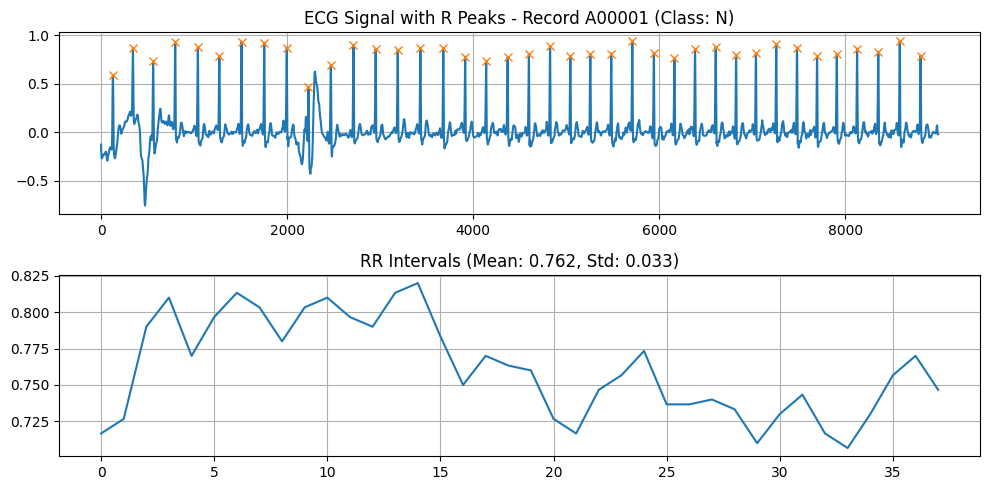

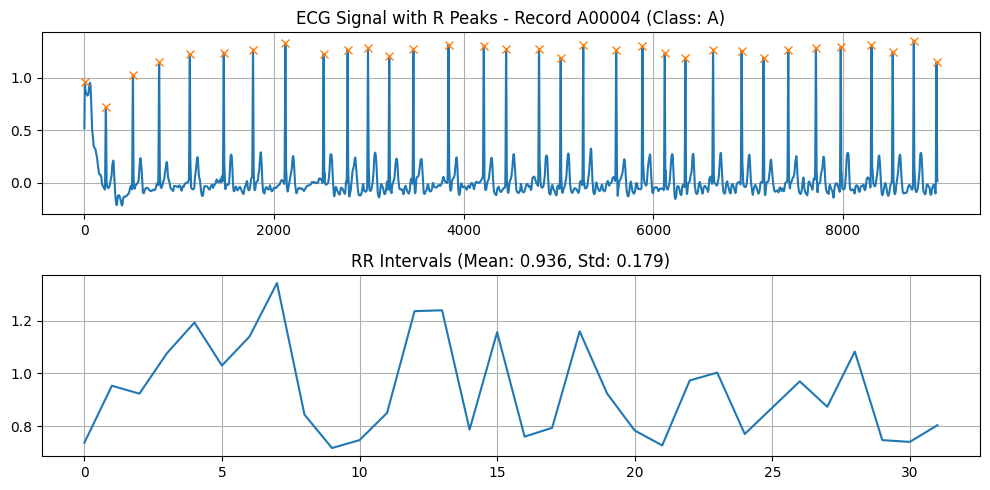

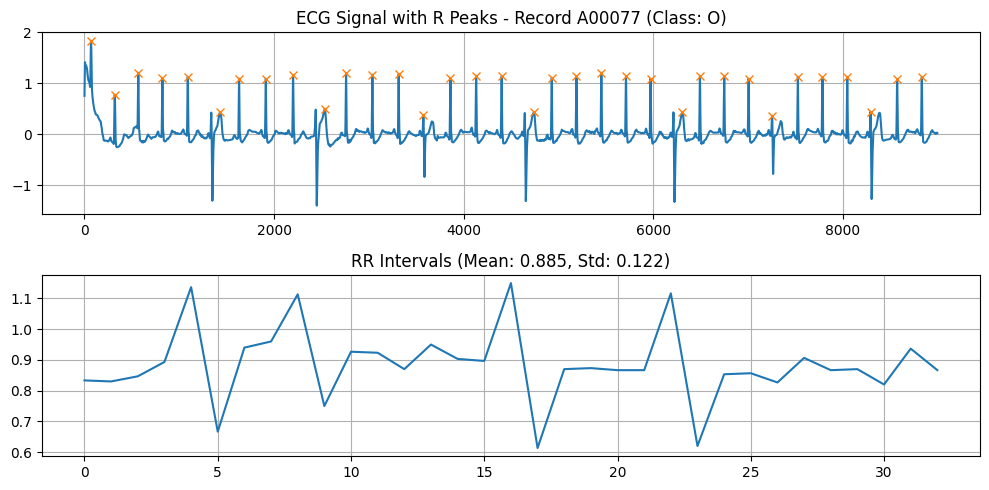

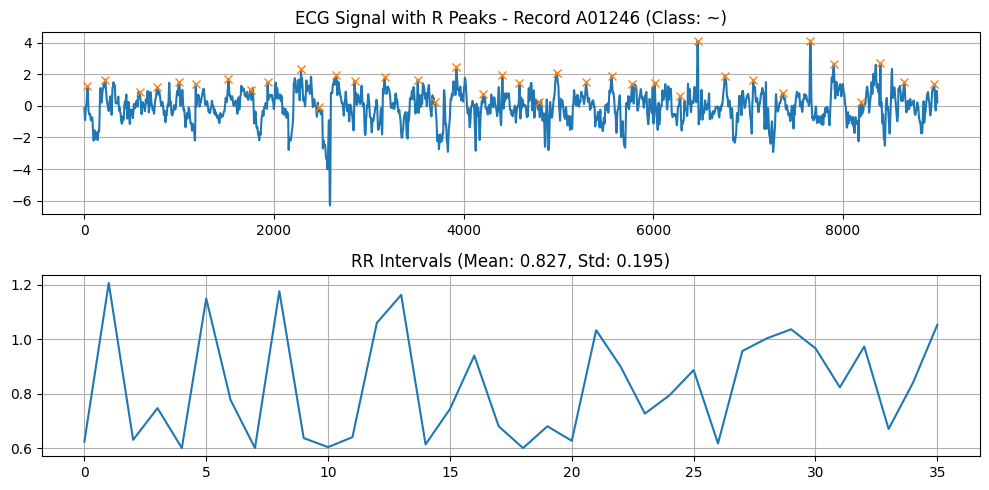


RR Interval Analysis Results:
  record_id label   mean_rr    std_rr     rmssd
0    A00001     N  0.761667  0.033173  0.023165
1    A00004     A  0.936042  0.178677  0.228134
2    A00077     O  0.885455  0.121580  0.206729
3    A01246     ~  0.827130  0.194919  0.296096


In [11]:
# Test on a few records
test_records = ['A00001', 'A00004', 'A00077', 'A01246']
results = []

for record_id in test_records:
    result = analyze_rr_intervals(record_id, 
                                  data_path, 
                                  labels_df,
                                  distance=0.6,
                                  plot=True)
    results.append(result)

# Create DataFrame with results
results_df = pd.DataFrame(results)
print("\nRR Interval Analysis Results:")
print(results_df)

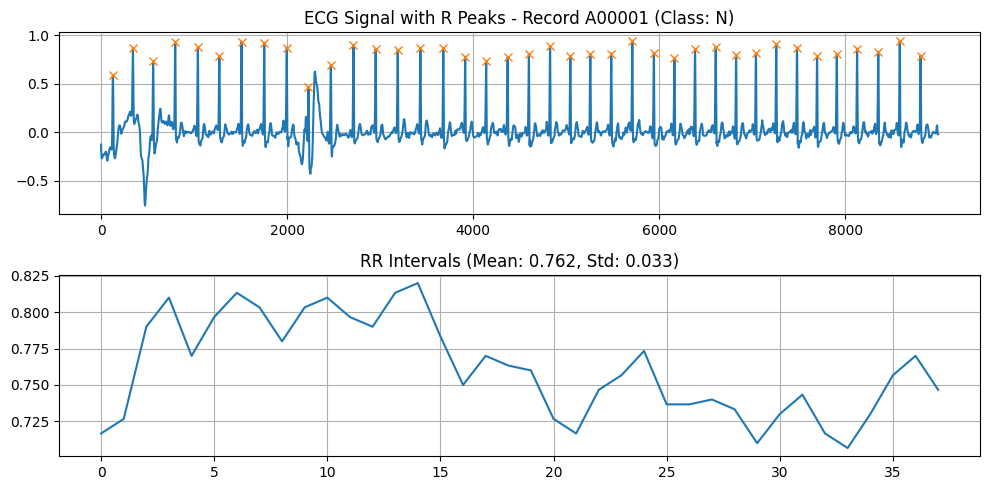

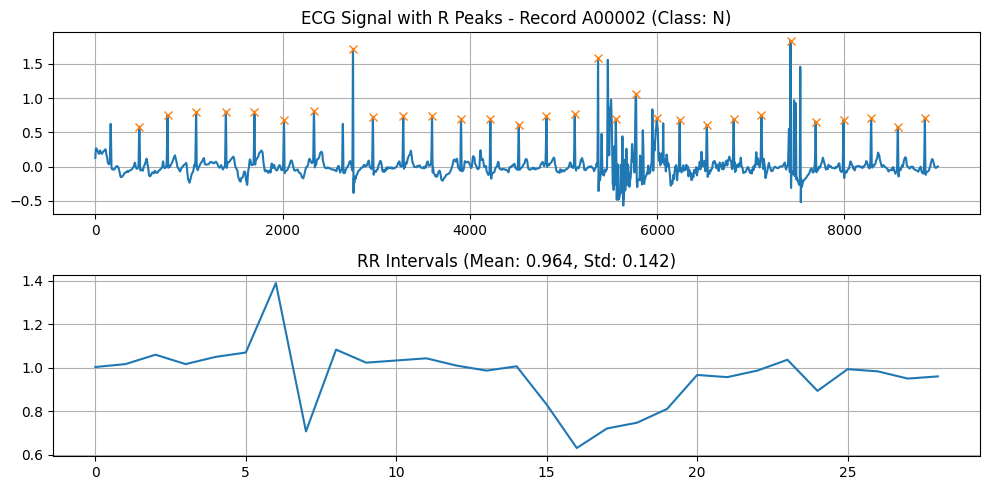

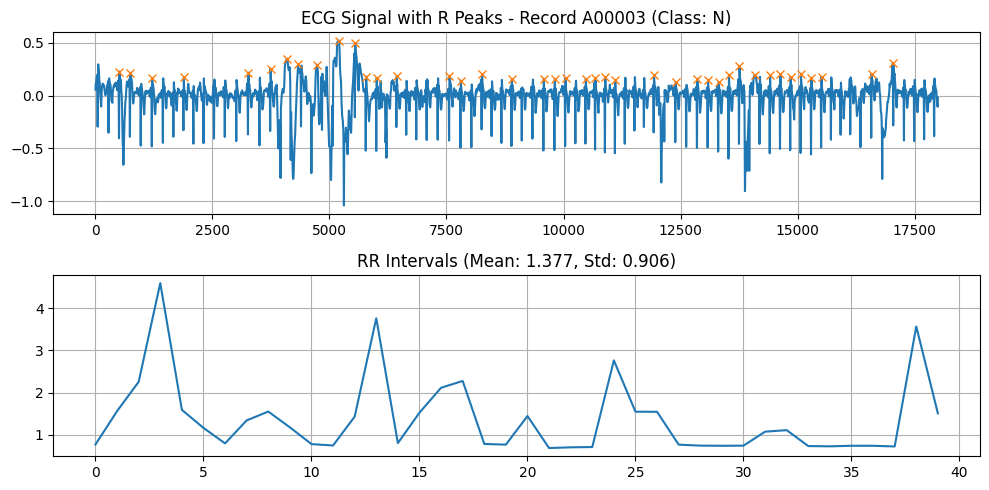

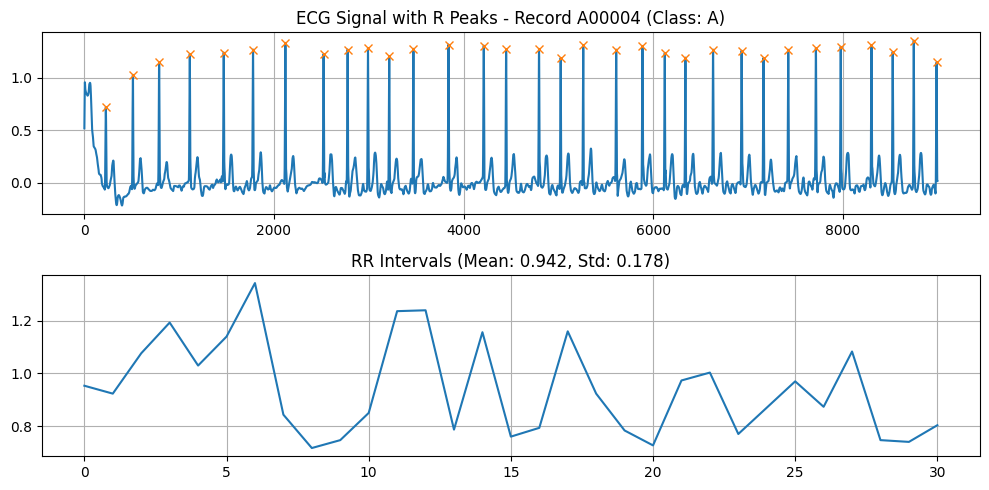

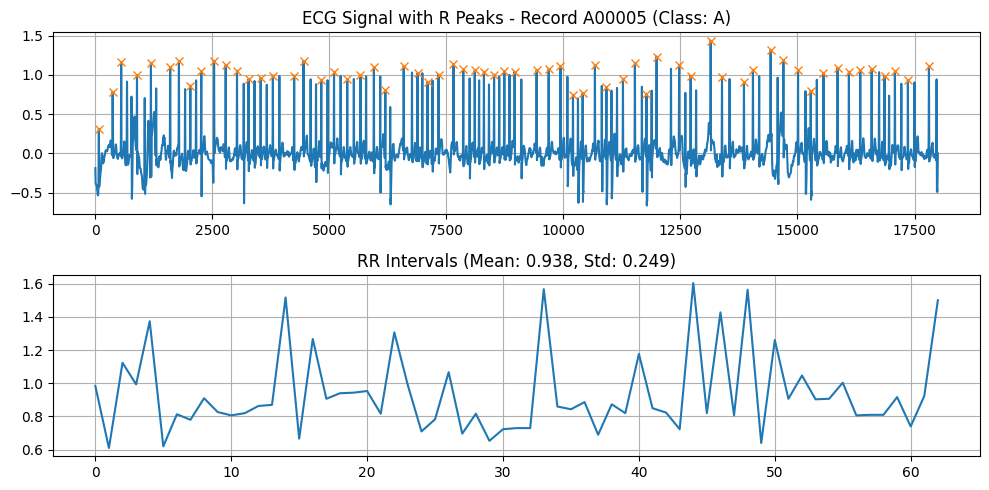

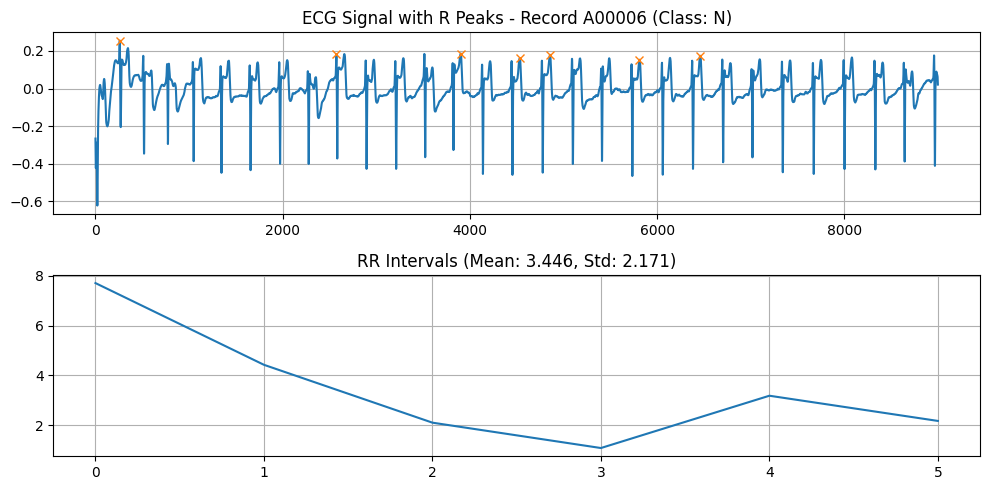

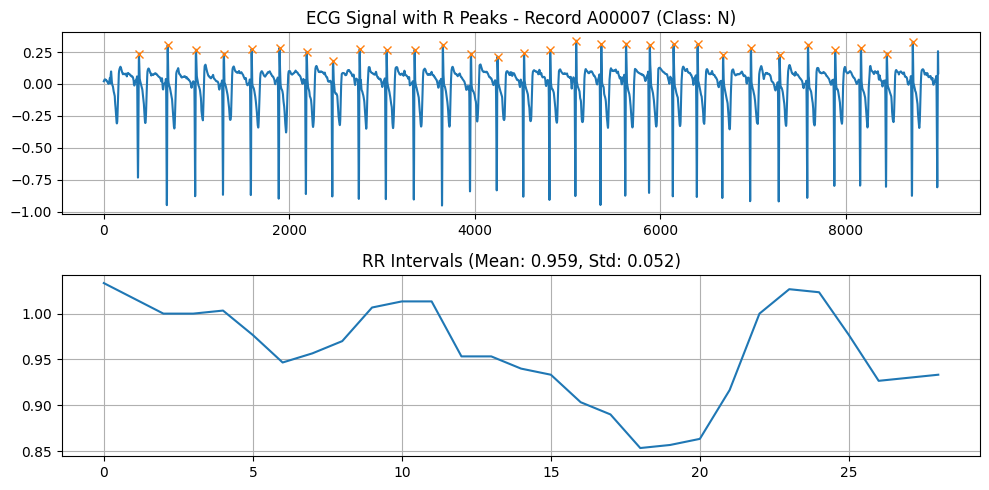

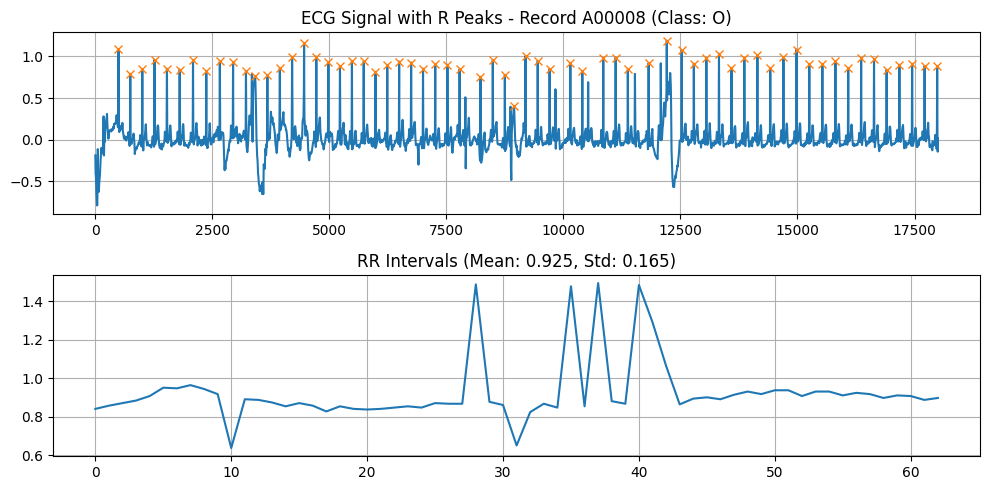

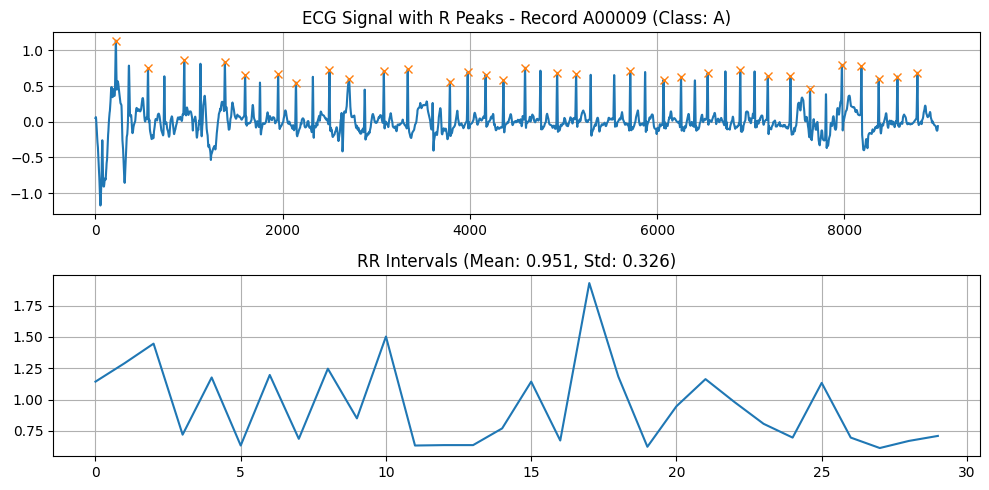

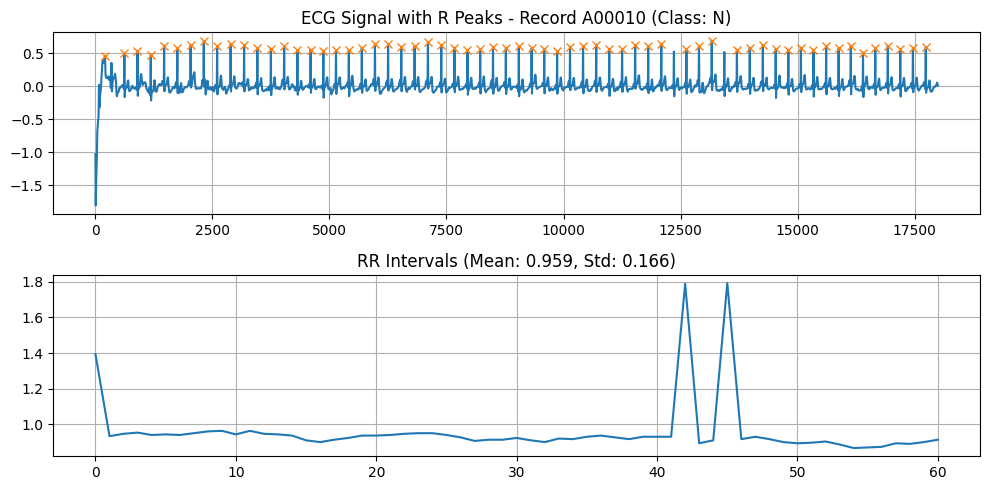

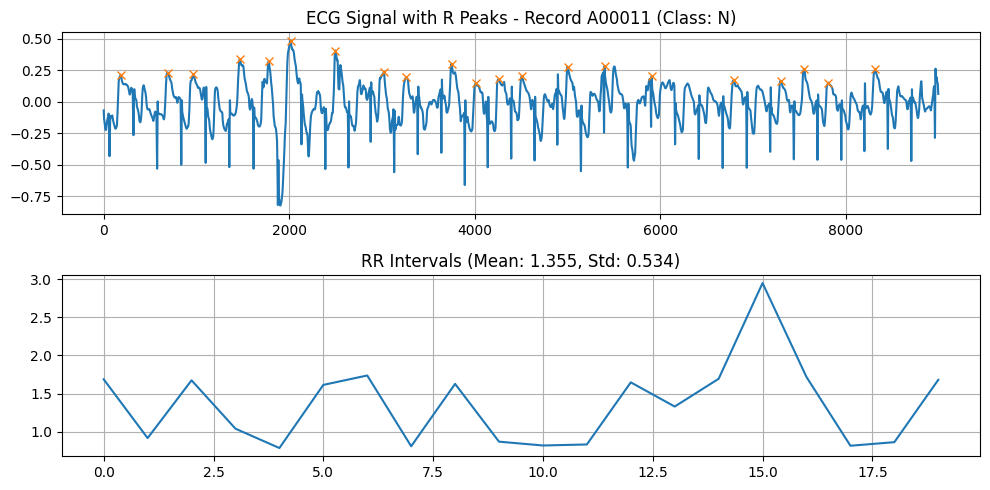

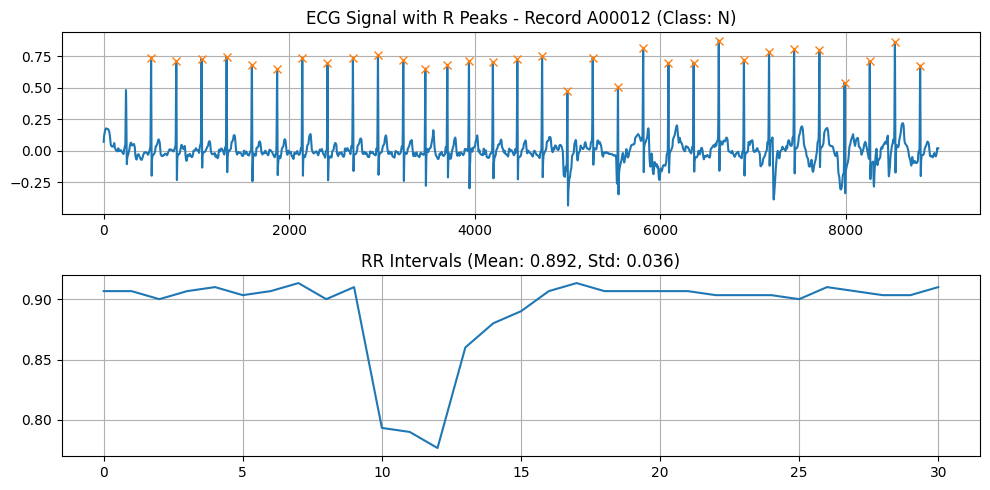

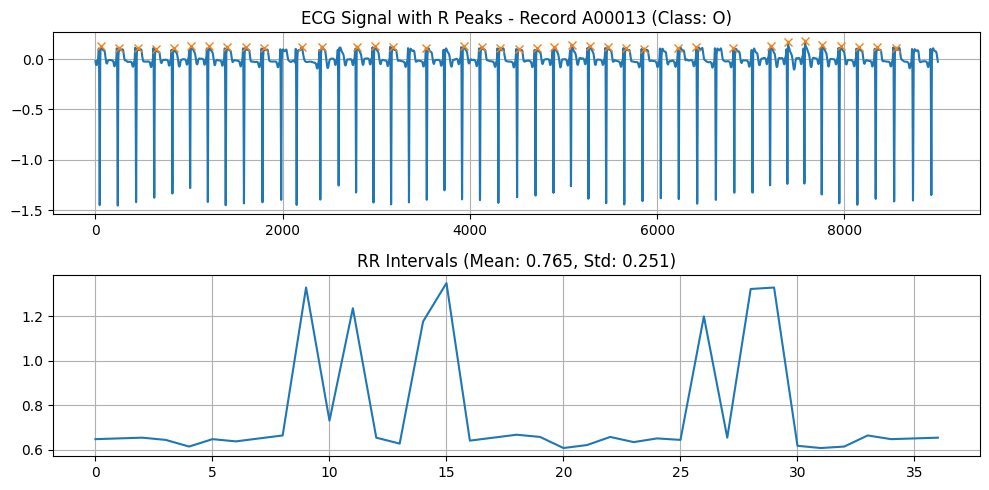

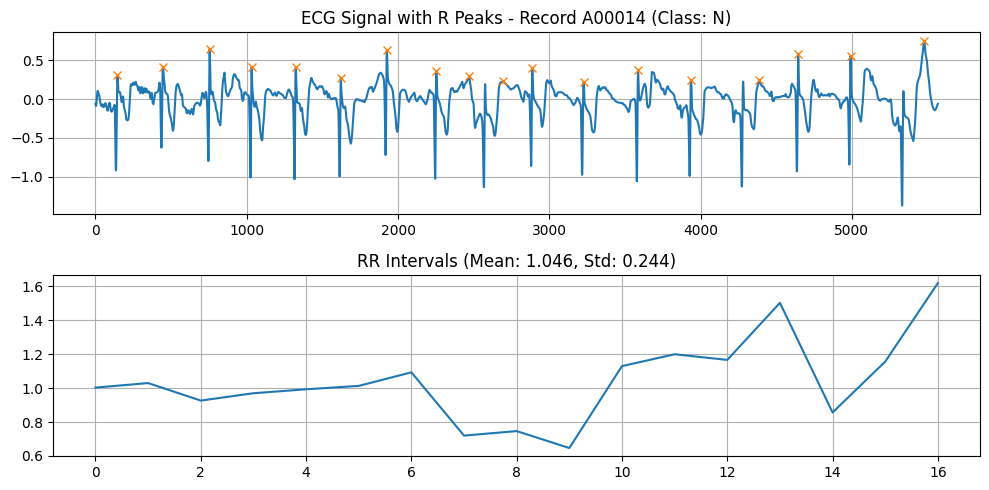

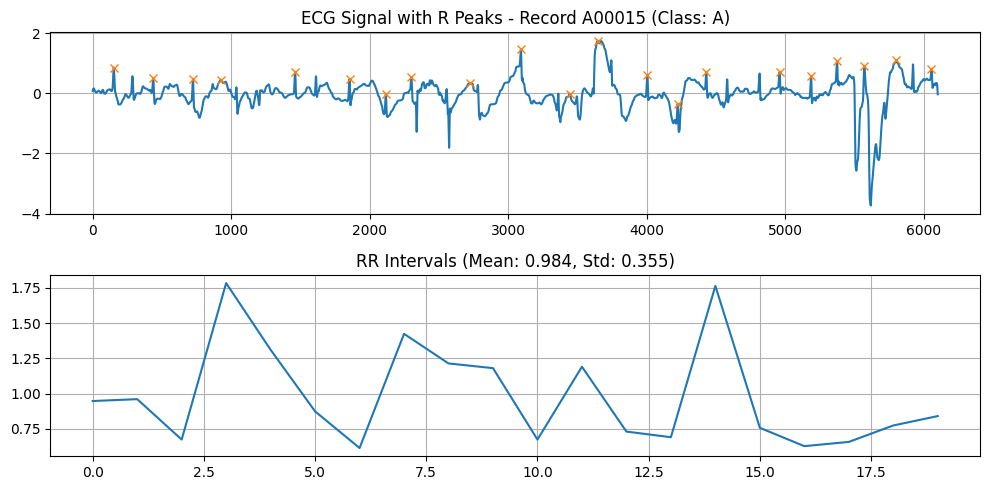

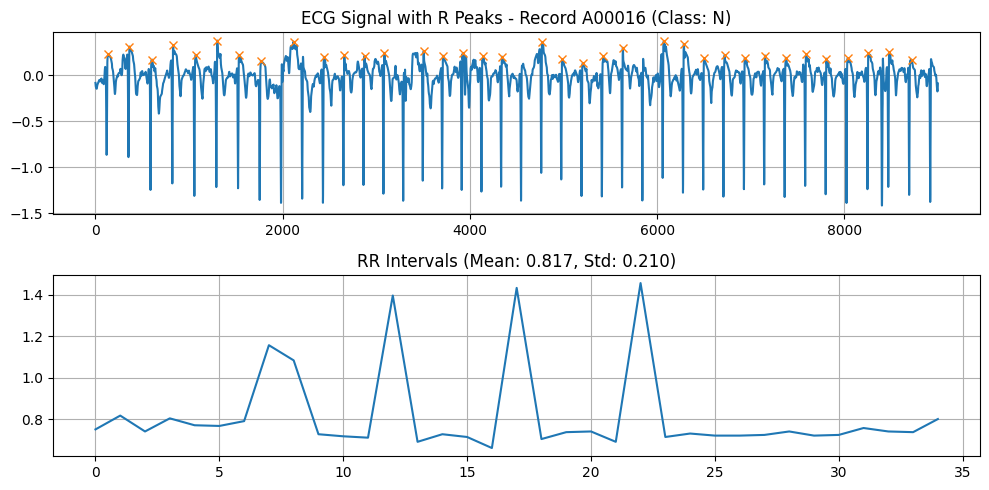

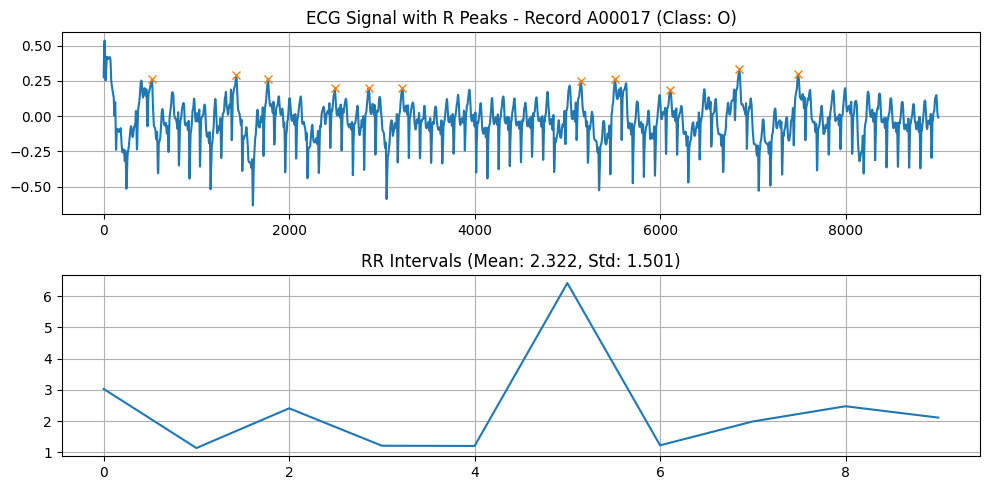

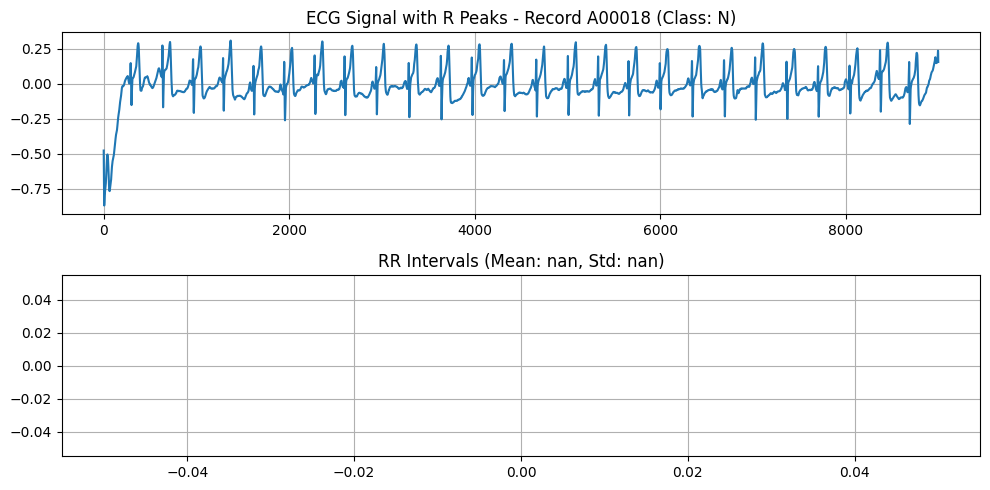

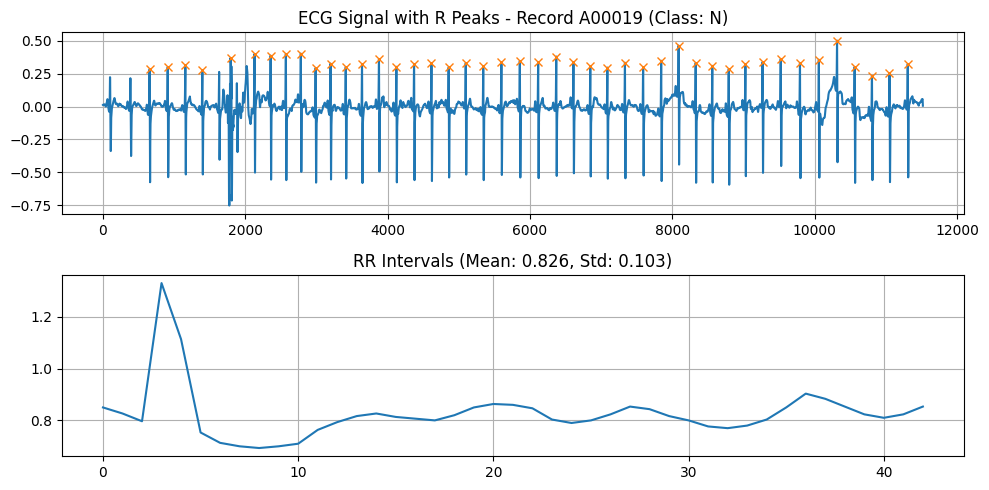

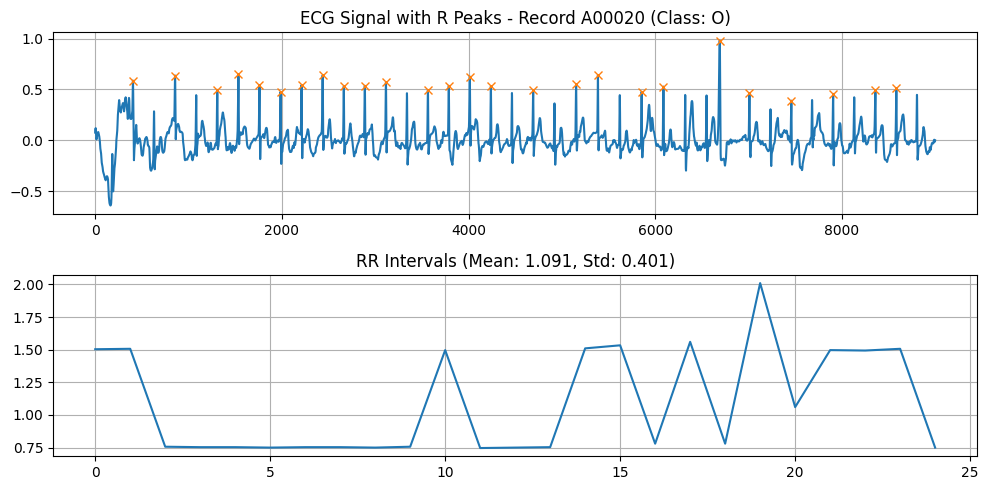


RR Interval Analysis Results:
      mean_rr                                                              \
        count      mean       std       min       25%       50%       75%   
label                                                                       
A         4.0  0.953987  0.020626  0.938307  0.941432  0.946903  0.959458   
N        11.0  1.218324  0.765748  0.761667  0.858728  0.959195  1.200510   
O         4.0  1.275715  0.710321  0.764595  0.885196  1.007965  1.398483   

                std_rr            ...                     rmssd            \
            max  count      mean  ...       75%       max count      mean   
label                             ...                                       
A      0.983833    4.0  0.277088  ...  0.333084  0.355405   4.0  0.410056   
N      3.445556   11.0  0.417916  ...  0.389230  2.170971  11.0  0.475519   
O      2.322333    4.0  0.579279  ...  0.675718  1.500766   4.0  0.928347   

                                           

In [12]:
# Test on a few records
results = []

for record_id in df['record_name'][:20]:
    result = analyze_rr_intervals(record_id, 
                                  data_path, 
                                  labels_df, 
                                  prominence=0.6,
                                  distance=0.6,
                                  plot=True)
    results.append(result)

# Create DataFrame with results
results_df = pd.DataFrame(results)
print("\nRR Interval Analysis Results:")
# display the summary of the results by label
print(results_df.groupby('label').describe())

In [27]:
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import wfdb  # Assuming WFDB is used for PhysioNet data
import matplotlib.pyplot as plt

# Bandpass filter for preprocessing
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=300, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

# R-R interval computation function
def compute_rr_intervals(signals, prominence=0, height=0, distance=0.6, sampling_rate=300):
    r_peaks, _ = find_peaks(signals, prominence=prominence, distance=int(distance * sampling_rate))
    rr_intervals = np.diff(r_peaks / sampling_rate)
    return rr_intervals, r_peaks

# Grid search function
def grid_search_rr_intervals(df, labels_df, prominence_values, distance_values, height_values=None):
    best_params = {'prominence': None, 'distance': None}
    best_score = -1
    results = []

    for prominence in prominence_values:
      for distance in distance_values:
        for zscoreFlag in [False, True]:
          for filterFlag in [False, True]:
            rr_intervals_by_class = {'N': [], 'A': [], 'O': [], '~': []}            
            for record_id in df['record_name']:
                # Read and preprocess each record
                record = wfdb.rdrecord(f'{data_path}/{record_id}')
                signals = record.p_signal.flatten()
                if zscoreFlag:
                    signals = (signals - np.mean(signals)) / np.std(signals)
                    # signals = zscore(signals)
                if filterFlag:
                  signals = bandpass_filter(signals, lowcut=0.5, highcut=40.0, fs=record.fs)
                
                # Label of the current record
                label = labels_df[labels_df.record_name == record_id].label.values[0]
                
                # Compute R-R intervals
                rr_intervals, r_peaks = compute_rr_intervals(signals, 
                                                              prominence=prominence, 
                                                              distance=distance, 
                                                              sampling_rate=record.fs)
                
                if len(rr_intervals) > 0:  # Append intervals if detected
                    rr_intervals_by_class[label].extend(rr_intervals)
            
            # Combine R-R intervals across all classes
            all_rr_intervals = np.concatenate([
                np.array(rr_intervals_by_class['N']).reshape(-1, 1),
                np.array(rr_intervals_by_class['A']).reshape(-1, 1),
                np.array(rr_intervals_by_class['O']).reshape(-1, 1),
                np.array(rr_intervals_by_class['~']).reshape(-1, 1)
            ])
            # Clustering
            kmeans = KMeans(n_clusters=4, random_state=42).fit(all_rr_intervals)
            score = silhouette_score(all_rr_intervals, kmeans.labels_)

            # Check if current parameters are the best
            if score > best_score:
                best_score = score
                best_params = {'prominence': prominence, 'distance': distance, 'zscore': zscoreFlag, 'filter': filterFlag}
                print(f'New best score: {best_score} with params: {best_params}')
            
            # Log results for analysis
            results.append({
                'prominence': prominence,
                'distance': distance,
                'zscore': zscoreFlag,
                'filter': filterFlag,
                'score': score
            })            
        

    # Print the best parameters and score
    print("Best Parameters:", best_params)
    print("Best Clustering Score:", best_score)
    
    # Return full grid search results for further analysis if needed
    return pd.DataFrame(results)

# Define parameter ranges
prominence_values = np.linspace(0.5, 0.7, 3)   # Adjust based on signal amplitude
distance_values = np.linspace(0.5, 0.7, 3)      # Adjust based on expected R-R intervals
height_values = np.linspace(0, 1.0, 5)          # Optional height values

# Run grid search
results_df = grid_search_rr_intervals(df[:500], 
                                      labels_df=labels_df, 
                                      prominence_values=prominence_values, 
                                      distance_values=distance_values, 
                                      height_values=height_values)
print(results_df)

New best score: 0.6736628842520112 with params: {'prominence': np.float64(0.5), 'distance': np.float64(0.5), 'zscore': False, 'filter': False}
New best score: 0.7508801567256792 with params: {'prominence': np.float64(0.5), 'distance': np.float64(0.5), 'zscore': False, 'filter': True}
New best score: 0.8982705966300009 with params: {'prominence': np.float64(0.6), 'distance': np.float64(0.5), 'zscore': False, 'filter': True}
New best score: 0.8994498543518177 with params: {'prominence': np.float64(0.6), 'distance': np.float64(0.6), 'zscore': False, 'filter': True}
Best Parameters: {'prominence': np.float64(0.6), 'distance': np.float64(0.6), 'zscore': False, 'filter': True}
Best Clustering Score: 0.8994498543518177
    prominence  distance  zscore  filter     score
0          0.5       0.5   False   False  0.673663
1          0.5       0.5   False    True  0.750880
2          0.5       0.5    True   False  0.540421
3          0.5       0.5    True    True  0.539312
4          0.5       0.

In [23]:
# # lets run the peak detection with the best parameters
# best_params = results_df.iloc[results_df['score'].idxmax()]
# print(best_params)

# Test on a few records
results = []

for i, record_id in enumerate(df['record_name']):
    result = analyze_rr_intervals(record_id, 
                                  data_path, 
                                  labels_df, 
                                  prominence=0.6,
                                  distance=0.6,
                                  plot=False)
    results.append(result)

    if i % 10 == 0:
        pd.DataFrame(results).to_csv(f'data/rr_kmeans_results.csv', index=False)

